# 自然语言处理第二次作业

王逸群 19307110397

## 0. 准备工作

### 0.1 过滤警告信息

In [1]:
import warnings
warnings.filterwarnings('ignore')

### 0.2 数据导入

数据集来源于Wikipedia，存储于`data.json`，包含10个类别10000个样本。

每个样本都是一个字典，包含三个键：`title`、`label`和`text`。

In [2]:
import json

In [3]:
dat = []
with open("data.json", "r") as file:
    for line in file:
        dat.append(json.loads(line))

### 0.3 数据预处理

在`dat`中增加两个键，存储样本中的句子和单词。

对每句话，保留英语单词和数字，去除标点符号和特殊字符。

其中，英语单词全都小写。

In [4]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

In [5]:
for sample in dat:
    sample['sent'] = [[word.lower() for word in word_tokenize(sent) if word.isdigit() or word.isalpha()] 
                      for sent in sent_tokenize(sample['text'])]
    sample['word'] = [word for sent in sample['sent'] for word in sent]

## 1. 词汇编码

以数据集作为训练集，使用`gensim`工具，生成CBOW词汇编码模型。

其中，超参数使用默认参数：

编码维度：`vector_size = 100`；

窗口大小：`window = 5`；

负采样参数：`negative = 5`；

初始学习率：`alpha = 0.025`。

In [6]:
from gensim.models import Word2Vec

In [7]:
sents = [sent for sample in dat for sent in sample['sent'] if sent != []]

In [ ]:
word2vec = Word2Vec(sents)

为了方便后续使用，保存模型：

In [ ]:
word2vec.save('word2vec.model')

后续使用以下代码载入模型：

In [8]:
word2vec = Word2Vec.load('word2vec.model')

## 2. 词汇相似度

首先，生成具有编码的词汇列表`word_common`:

In [9]:
import itertools
from collections import Counter

In [10]:
word_counts = Counter(itertools.chain.from_iterable(sents))
word_common = [word for word, count in word_counts.items() if count >= 5]

随机生成100、1000、10000对词汇，对每个词汇集合，以余弦相似度作为度量，打印5对最相似和5对最不相似的词汇。

In [11]:
import random

In [12]:
random.seed(0)

In [13]:
for num in (100, 1000, 10000):
    word_similar = []
    word_unsimilar = []
    dist_similar = []
    dist_unsimilar = []
    
    for _ in range(num):
        word_sample = random.sample(word_common, 2)
        dist = word2vec.wv.similarity(word_sample[0], word_sample[1])

        if len(dist_similar) < 5:
            word_similar.append([word_sample[0], word_sample[1]])
            dist_similar.append(dist)
        elif dist > min(dist_similar):
            index = dist_similar.index(min(dist_similar))
            word_similar[index] = [word_sample[0], word_sample[1]]
            dist_similar[index] = dist
            
        if len(dist_unsimilar) < 5:
            word_unsimilar.append([word_sample[0], word_sample[1]])
            dist_unsimilar.append(dist)
        elif dist < max(dist_unsimilar):
            index = dist_unsimilar.index(max(dist_unsimilar))
            word_unsimilar[index] = [word_sample[0], word_sample[1]]
            dist_unsimilar[index] = dist
    
    print('Within', num, 'word pairs, the most similar and unsimilar words:')
    print('words\t\t\t\t\tdistance')
    for index in range(5):
        print('%-20s%-20s%8.5f' % (word_similar[index][0], word_similar[index][1], dist_similar[index]))
    for index in range(5):
        print('%-20s%-20s%8.5f' % (word_unsimilar[index][0], word_unsimilar[index][1], dist_unsimilar[index]))
    print()

Within 100 word pairs, the most similar and unsimilar words:
words					distance
activesync          reselected           0.69320
spector             monroes              0.53782
bolognesi           koss                 0.54482
gatchina            oceanside            0.76862
nantz               byrek                0.60405
uiți                freed               -0.10843
incarcerated        domestically        -0.06718
wag                 gotten              -0.07614
photojournalist     showing             -0.12385
steroid             brannon             -0.06870

Within 1000 word pairs, the most similar and unsimilar words:
words					distance
graphing            kayani               0.74682
yojana              ludhiana             0.74324
molnár              mihajlović           0.77804
wāka                1023                 0.80624
bhimrao             sudeshna             0.78051
retained            gregoire            -0.26716
full                jochen              -0.25174
srami

可以看到，虽然出现了一些陌生的词汇，有一些词汇相似度是可解释的：

|词汇|词汇|词汇集合编号|直观距离|模型距离|
|:--|:--|:--:|:--:|:--:|
|incarcerated|domestically|1|远|远|
|wag|gotten|1|远|远|
|printed|nora|2|远|远|
|conjectured|adequately|3|远|远|
|alina|necessity|3|远|远|
|photojournalist|showing|1|近|远|
|relationships|voyager|2|近|远|
|units|spiro|3|近|远|

进而看到，模型距离较近的词汇对解释性较差，词汇集合大小对结果的影响较小。

## 3. 文档编码

分别使用词汇编码均值、第一段词汇编码均值、文档编码算法三种方法进行文档编码，接着使用k均值聚类算法评估各方法，并使用t-SNE进行可视化。

其中k均值聚类代码如下：

In [14]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters = 10, random_state = 0).fit(dv)

为了分辨聚类结果对应的`label`，定义如下函数：

In [15]:
def align(labels_):
    global dat
    table = {}
    
    for index in range(10000):
        if dat[index]['label'] not in table.keys():
            table[dat[index]['label']] = [0 for _ in range(10)]
        table[dat[index]['label']][labels_[index]] += 1
    
    print('label\t\t0\t1\t2\t3\t4\t5\t6\t7\t8\t9')
    for key in table.keys():
        print('%-12s' % key, end = '\t')
        for index in range(10):
            print(table[key][index], end = '\t')
        print()

使用随机Rand调整指数评估模型代码如下：

In [16]:
from sklearn.metrics import adjusted_rand_score

In [17]:
labels = [sample['label'] for sample in dat]

In [ ]:
jaccard_score(labels, kmeans.labels_)

使用t-SNE进行可视化的代码封装为函数：

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [19]:
def tsne(dv):
    global labels
    labels = np.array(labels)
    position = TSNE(n_components = 2, learning_rate = 1.2, init = 'pca').fit_transform(dv)
    
    plt.scatter(position[labels == 'Film', 0], position[labels == 'Film', 1], c = "tab:blue")
    plt.scatter(position[labels == 'Book', 0], position[labels == 'Book', 1], c = "tab:orange")
    plt.scatter(position[labels == 'Politician', 0], position[labels == 'Politician', 1], c = "tab:green")
    plt.scatter(position[labels == 'Writer', 0], position[labels == 'Writer', 1], c = "tab:red")
    plt.scatter(position[labels == 'Food', 0], position[labels == 'Food', 1], c = "tab:purple")
    plt.scatter(position[labels == 'Actor', 0], position[labels == 'Actor', 1], c = "tab:brown")
    plt.scatter(position[labels == 'Animal', 0], position[labels == 'Animal', 1], c = "tab:pink")
    plt.scatter(position[labels == 'Software', 0], position[labels == 'Software', 1], c = "tab:gray")
    plt.scatter(position[labels == 'Artist', 0], position[labels == 'Artist', 1], c = "tab:olive")
    plt.scatter(position[labels == 'Disease', 0], position[labels == 'Disease', 1], c = "tab:cyan")
    plt.legend(['Film', 'Book', 'Politician', 'Writer', 'Food', 'Actor', 'Animal', 'Software', 'Artist', 'Disease'])

### 3.1 使用词汇编码均值

In [ ]:
dv = []

for sample in dat:
    total = 0
    count = 0
    
    for word in sample['word']:
        if word in word_common:
            total += word2vec.wv[word]
            count += 1
    dv.append(total / count)

为了方便后续使用，保存编码：

In [20]:
import pickle

In [ ]:
with open('dv_whole.dat', 'wb') as file:
    pickle.dump(dv, file)

后续使用以下代码导入编码：

In [21]:
with open('dv_whole.dat', 'rb') as file:
    dv = pickle.load(file)

使用k均值聚类算法:

In [22]:
kmeans = KMeans(n_clusters = 10, random_state = 0).fit(dv)

In [23]:
align(kmeans.labels_)

label		0	1	2	3	4	5	6	7	8	9
Film        	3	2607	1	2	36	76	1	1	19	302	
Book        	6	26	6	3	121	441	1	2	21	348	
Politician  	0	28	1152	793	63	41	1	989	733	24	
Writer      	0	42	10	12	606	90	0	6	29	42	
Food        	128	3	0	0	4	2	0	0	0	0	
Actor       	1	62	0	0	16	0	0	0	0	1	
Animal      	86	0	0	0	1	6	0	0	0	0	
Software    	8	3	1	0	0	1	253	0	0	0	
Artist      	0	18	2	2	465	25	1	0	2	5	
Disease     	213	0	1	0	0	5	0	0	1	0	


可以看到，聚类结果与`label`无法一一对应。

使用随机Rand调整指数评估模型：

In [24]:
print('ARI: %.6f' % adjusted_rand_score(labels, kmeans.labels_))

ARI: 0.466842


可以看到，结果较好。

使用t-SNE进行可视化：

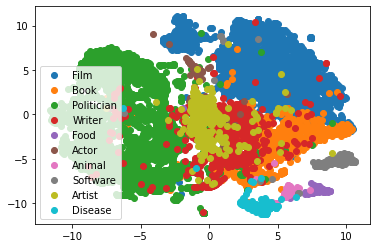

In [25]:
tsne(dv)

可以看到，聚类的效果较明显。

### 3.2 使用第一段词汇编码均值

In [ ]:
dv = []

for sample in tqdm(dat):
    total = 0
    count = 0
    
    if '\n' in sample['text']:
        word_first = [word.lower() 
                      for sent in sent_tokenize(sample['text'].lstrip(' \n')[:sample['text'].lstrip(' \n').find('\n')]) 
                      for word in word_tokenize(sent) if word.isdigit() or word.isalpha()]
    else:
        word_first = sample['word']
        
    for word in word_first:
        if word in word_common:
            total += word2vec.wv[word]
            count += 1
    dv.append(total / count)

为了方便后续使用，保存编码：

In [ ]:
with open('dv_first.dat', 'wb') as file:
    pickle.dump(dv, file)

后续使用以下代码导入编码：

In [26]:
with open('dv_first.dat', 'rb') as file:
    dv = pickle.load(file)

使用k均值聚类算法:

In [27]:
kmeans = KMeans(n_clusters = 10, random_state = 0).fit(dv)

In [28]:
align(kmeans.labels_)

label		0	1	2	3	4	5	6	7	8	9
Film        	0	534	8	0	93	19	1117	2	1271	4	
Book        	1	218	34	1	625	28	6	0	56	6	
Politician  	1072	10	1	357	63	1271	4	1025	17	4	
Writer      	5	147	1	111	427	106	11	5	24	0	
Food        	0	1	127	0	9	0	0	0	0	0	
Actor       	0	29	0	17	5	1	11	1	15	1	
Animal      	0	0	84	0	6	2	1	0	0	0	
Software    	0	2	8	0	7	0	0	0	4	245	
Artist      	1	36	4	75	306	76	4	1	16	1	
Disease     	0	0	219	0	1	0	0	0	0	0	


可以看到，聚类结果与`label`无法一一对应。

使用随机Rand调整指数评估模型：

In [29]:
print('ARI: %.6f' % adjusted_rand_score(labels, kmeans.labels_))

ARI: 0.313592


可以看到，在计算量大幅减小的条件下，结果保持得较好。

使用t-SNE进行可视化：

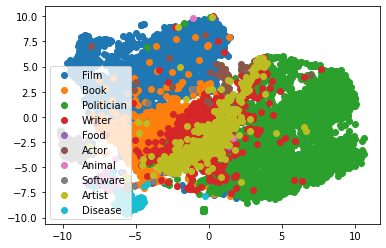

In [30]:
tsne(dv)

### 3.3 使用文档编码算法

In [31]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

In [ ]:
docs = [TaggedDocument(sample['word'], [sample['title']]) for sample in dat]
doc2vec = Doc2Vec(docs, min_count = 1)

同样地，为了方便后续使用，保存模型：

In [ ]:
doc2vec.save('doc2vec.model')

后续使用以下代码载入模型：

In [32]:
doc2vec = Doc2Vec.load('doc2vec.model') 

使用k均值聚类算法:

In [33]:
dv = [doc2vec.dv[sample['title']] for sample in dat]
kmeans = KMeans(n_clusters = 10, random_state = 0).fit(dv)

In [34]:
align(kmeans.labels_)

label		0	1	2	3	4	5	6	7	8	9
Film        	122	457	51	137	800	193	1002	127	12	147	
Book        	75	15	146	62	131	84	139	100	122	101	
Politician  	322	178	584	545	377	815	38	354	17	594	
Writer      	33	22	136	57	154	65	59	178	11	122	
Food        	28	2	2	7	13	2	3	3	72	5	
Actor       	1	9	0	18	19	4	20	1	1	7	
Animal      	0	0	0	0	0	0	6	0	87	0	
Software    	1	1	0	7	8	16	142	0	89	2	
Artist      	11	6	94	65	136	44	24	81	5	54	
Disease     	1	0	0	5	5	11	4	0	192	2	


可以看到，聚类结果与`label`无法一一对应。

使用随机Rand调整指数评估模型：

In [35]:
print('ARI: %.6f' % adjusted_rand_score(labels, kmeans.labels_))

ARI: 0.093631


可以看到，结果一般。可能的原因是，对于文档编码而言，训练数据太少。

使用t-SNE进行可视化：

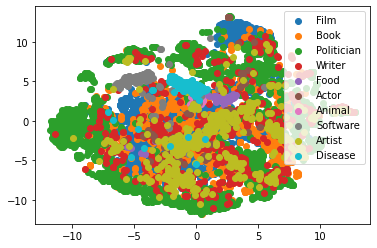

In [36]:
tsne(dv)

可以看到，聚类的效果并不明显。